Momentum Trading Strategy implemented in Python on a 500 Stocks universe [Beginner friendly]
By AlgoVibes (Youtube)
https://www.youtube.com/watch?v=L2nhNvIAyBI

Description:<br>
Get list of S&P500 stocks<br>
Download price data for all<br>
Concatenate into one dataframe<br>
Calculate percent change<br>
Resample to monthly period<br>

To Do:<br>
    v3: Add daily trailing stop. After stop triggers, don't get back in until next month<br>
        Alternatively, get back in after things go positive<br>
        Implmentation:<br>
            Option 1:  Don't resample data to monthly, just get a monthly index, then loop through monthly periods.<br>
            Keep track of highest price as you iterate through daily prices. If price ever drops by more than stop amount, set rest of prices = cash return (0).<br>
    v3.1<br>
        Add new dataframe to keep track of our regime filters<br>
        Add "regime filter" to help determine if you should be in cash. <br>
        Filters:<br>
            SPY < 200 day<br>
            Market breadth increasing / shrinking<br>
    v3.2:  Iterate through possible weighting combinations using itertools.<br>
    v.3.3  Better stock selection:<br>
        Calculate 30-day volume for all stocks in universe at beginning of start_date<br>
        Take highest 100<br>
        Calculate volume changes for top 100 stocks by volume, then select the ones with highest average volume increase over 30 day period (unusual volume)<br>
        

In [1]:
#Import libraries
import sys
import datetime as dt
import yfinance as yf
import pandas as pd
import numpy as np
from pandas.tseries.offsets import MonthEnd
%matplotlib inline
import quantstats as qs
qs.extend_pandas() # # extend pandas functionality with metrics, etc.
sys.path.append('/home/lantro/Documents/Algo Trading/Stock Price DB/')
#from get_ticker_data_from_db_v2 import process_ticker
from StockPriceData import process_ticker

In [2]:
#Set variables 
data_folder = '/home/lantro/Documents/Algo Trading/Data'
start_date = '2000-01-01'#'1962-01-02'
end_date = '2022-08-23'
get_latest_data = True # Getting latest prices from DB is slow, so we can read previously created csv
tickers = ['AAPL','AMZN','NFLX','AMD','NVDA','MSFT','WMT','IBM','KO','PSX','PG','BAC','WFC']
benchmark = ['^GSPC']


In [3]:
# NOTE: when we get price df, we may want to replace all values below a certain threshold with 0 so that our algo doesn't
# trade them since they may appear to have great returns at times even though they're uninvestible at the time such as when they first list.
# We should replace small values from beginning of df until the price meets our threshold. We probably want to leave in prices when they go below our threshold later.
def get_prices(tickers):
    if get_latest_data == True:
        prices, symbols = [],[]
        for ticker in tickers:
            print(f'Processing {ticker}')
            try:
                #df = process_ticker(ticker,end_date)['Adj_Close']
                df = process_ticker(ticker,start_date,end_date)['Adj_Close']
                if not df.empty:
                    print(f'Appending {ticker} to prices and symbols lists')
                    prices.append(df)
                    symbols.append(ticker)
            except:
                print(f'Unable to download data for {ticker}')
            
        all_prices = pd.concat(prices,axis=1) #Concatenate all ticker price dfs to one df
        all_prices.columns = symbols # Rename column names based on tickers
        all_prices.to_csv(f"{data_folder}/all_sp500_prices.csv", index=True) #Index is date
    else:
        #all_prices = pd.read_csv(f"{data_folder}/all_sp500_prices.csv", index_col=[0], header=0, parse_dates=True) #Index is date
        all_prices = pd.read_csv(f"{data_folder}/all_sp500_prices.csv", index_col='Date', parse_dates=True)
        #all_prices.index = pd.to_datetime(all_prices.index) #Not necessary if dates are parsed properly
    return(all_prices)

all_prices = get_prices(tickers)
#benchmark_prices = get_prices(benchmark)

Processing AAPL
Retrieving price data for AAPL from 2000-01-01 - 2022-08-23
Connecting to DB on rpi4.
Latest price data for AAPL (2022-12-02) >= required end date (2022-08-23).
(5696, 8)
Appending AAPL to prices and symbols lists
Processing AMZN
Retrieving price data for AMZN from 2000-01-01 - 2022-08-23
Connecting to DB on rpi4.
Latest price data for AMZN (2022-12-02) >= required end date (2022-08-23).
(5696, 8)
Appending AMZN to prices and symbols lists
Processing NFLX
Retrieving price data for NFLX from 2000-01-01 - 2022-08-23
Connecting to DB on rpi4.
Latest price data for NFLX (2022-12-02) >= required end date (2022-08-23).
(5099, 8)
Appending NFLX to prices and symbols lists
Processing AMD
Retrieving price data for AMD from 2000-01-01 - 2022-08-23
Connecting to DB on rpi4.
Latest price data for AMD (2022-12-02) >= required end date (2022-08-23).
(5696, 8)
Appending AMD to prices and symbols lists
Processing NVDA
Retrieving price data for NVDA from 2000-01-01 - 2022-08-23
Connecti

In [4]:
#benchmark_prices.head()

In [5]:
#prices
#symbols
#all_prices.index
all_prices.head()
all_prices.tail(10)
#all_prices[all_prices > 0]
latest_date_for_all = all_prices.dropna().index[-1] #This is the latest date where all tickers have data
all_prices = all_prices.loc[:latest_date_for_all,:] #Trimming df to last date where all tickers had data
all_prices.head()

,AAPL,AMZN,NFLX,AMD,NVDA,MSFT,WMT,IBM,KO,PSX,PG,BAC,WFC
Date,,,,,,,,,,,,,
2000-01-03,0.86,89.38,NaN,15.50,0.90,36.93,45.26,72.09,15.69,NaN,30.06,13.89,10.77
2000-01-04,0.79,81.94,NaN,14.62,0.87,35.68,43.57,69.64,15.71,NaN,29.48,13.07,10.24
2000-01-05,0.80,69.75,NaN,15.00,0.84,36.06,42.68,72.09,15.85,NaN,28.92,13.21,10.13
2000-01-06,0.73,65.56,NaN,16.00,0.79,34.85,43.15,70.84,15.86,NaN,30.25,14.34,10.58
2000-01-07,0.76,69.56,NaN,16.25,0.80,35.31,46.41,70.53,16.91,NaN,32.67,13.97,10.77


In [6]:
# See  how much data we have for each ticker
for column in all_prices.columns[:-1]:
    prices = all_prices[column][all_prices[column]>0]
    print(f'{column}:\t{prices.index[0]} - {prices.index[-1]}')

AAPL:	2000-01-03 00:00:00 - 2022-08-23 00:00:00
AMZN:	2000-01-03 00:00:00 - 2022-08-23 00:00:00
NFLX:	2002-05-23 00:00:00 - 2022-08-23 00:00:00
AMD:	2000-01-03 00:00:00 - 2022-08-23 00:00:00
NVDA:	2000-01-03 00:00:00 - 2022-08-23 00:00:00
MSFT:	2000-01-03 00:00:00 - 2022-08-23 00:00:00
WMT:	2000-01-03 00:00:00 - 2022-08-23 00:00:00
IBM:	2000-01-03 00:00:00 - 2022-08-23 00:00:00
KO:	2000-01-03 00:00:00 - 2022-08-23 00:00:00
PSX:	2012-04-12 00:00:00 - 2022-08-23 00:00:00
PG:	2000-01-03 00:00:00 - 2022-08-23 00:00:00
BAC:	2000-01-03 00:00:00 - 2022-08-23 00:00:00


In [7]:
#Calculate monthly returns
if get_latest_data == True:
    all_daily_ret = all_prices.pct_change()
    all_daily_ret['CASH'] = 0 # Add alternative for condition where everything is negative 
    all_daily_ret.to_csv(f"{data_folder}/all_daily_ret.csv", index=True) #Index is date
    all_mtl_ret = all_prices.pct_change().resample('M').agg(lambda x : (x + 1).prod() -1)
    all_mtl_ret['CASH'] = 0 # Add alternative for condition where everything is negative 
    all_mtl_ret.to_csv(f"{data_folder}/all_mtl_ret.csv", index=True) #Index is date
else:
    all_daily_ret = pd.read_csv(f"{data_folder}/all_daily_ret.csv", index_col='Date', parse_dates=True) #Index is date
    all_mtl_ret = pd.read_csv(f"{data_folder}/all_mtl_ret.csv", index_col='Date', parse_dates=True) #Index is date
# IMPORTANT: We need to remove NaN and inf values from percentage returns df since stocks that trade at very low prices or zero will have
# crazy return calculations when prices go from 0 to anything or vice versa.
all_daily_ret = all_daily_ret.replace([np.inf, -np.inf, np.nan], 0)
all_mtl_ret = all_mtl_ret.replace([np.inf, -np.inf, np.nan], 0)
#Create a new prices df of only companies that have prices going back to the earliest date
#earliest_prices = all_prices.loc[:, all_prices.iloc[0] > 0]


In [8]:
all_daily_ret.index
all_daily_ret.tail()

,AAPL,AMZN,NFLX,AMD,NVDA,MSFT,WMT,IBM,KO,PSX,PG,BAC,WFC,CASH
Date,,,,,,,,,,,,,,
2022-08-17,0.008785,-0.018511,-0.018479,-0.019261,-0.028815,-0.002636,0.001076,0.009007,-0.002307,0.016744,-0.004602,-0.006277,0.001737,0
2022-08-18,-0.002292,0.001407,0.016670,0.022082,0.023889,-0.003948,-0.003225,0.009289,0.005240,-0.013130,0.003551,-0.003570,0.000000,0
2022-08-19,-0.015102,-0.028602,-0.016356,-0.044703,-0.049220,-0.013854,-0.014741,-0.005033,-0.000767,-0.002819,-0.000267,-0.022051,-0.017122,0
2022-08-22,-0.023029,-0.036244,-0.060624,-0.032413,-0.045661,-0.029355,-0.017881,-0.020380,-0.014884,-0.002374,-0.002671,-0.021421,-0.020728,0
2022-08-23,-0.002029,0.003003,-0.008784,-0.003770,0.008630,-0.004716,-0.004236,-0.005976,0.001090,0.036042,-0.019286,-0.008929,-0.000901,0


In [9]:
all_mtl_ret.index
all_mtl_ret.tail()

,AAPL,AMZN,NFLX,AMD,NVDA,MSFT,WMT,IBM,KO,PSX,PG,BAC,WFC,CASH
Date,,,,,,,,,,,,,,
2022-04-30,-0.097131,-0.237525,-0.491818,-0.217853,-0.320274,-0.099867,0.027330,0.016844,0.042097,0.004283,0.050720,-0.134401,-0.099670,0
2022-05-31,-0.055883,-0.032764,0.037193,0.191066,0.006740,-0.020359,-0.159226,0.050147,-0.019037,0.161941,-0.078916,0.036715,0.049049,0
2022-06-30,-0.081430,-0.955823,-0.114313,-0.249264,-0.188143,-0.055321,-0.054808,0.016926,-0.007416,-0.186688,-0.027658,-0.158421,-0.144199,0
2022-07-31,0.188634,0.270596,0.286098,0.235386,0.198166,0.093097,0.086116,-0.073660,0.020029,0.085498,-0.033938,0.086091,0.119990,0
2022-08-31,0.029044,-0.009856,-0.001556,-0.020959,-0.054066,-0.015317,0.014767,0.030201,0.001558,0.027079,0.054280,0.017746,0.011397,0


In [10]:
# Instead  of using something like the S&P500 as benchmark, we'll use an equal-weighted average of the returns for our defined assets
#benchmark_returns = benchmark_prices.pct_change().dropna()
benchmark_returns = all_prices.pct_change().dropna().mean(axis=1)
#benchmark_monthly_returns = benchmark_prices.pct_change().resample('M').agg(lambda x : (x + 1).prod() -1)
benchmark_monthly_returns = all_mtl_ret.mean(axis=1)
#all_prices.tail().pct_change()#.dropna(axis=0)

In [11]:
benchmark_returns
benchmark_monthly_returns.head()

Date
2000-01-31   -0.055969
2000-02-29    0.015206
2000-03-31    0.104774
2000-04-30   -0.009981
2000-05-31    0.010852
Freq: M, dtype: float64

Put it all together into a function that takes a lookback period (instead of just 12 months)

In [12]:
def trailing_stop_indiv(period_daily_ret, stop_loss):
    # This function just calculates a trailing stop on returns of each stock that are passed to it.
    # If the return for any portfolio stocks fall below the stop loss level,
    # the remaining return values for that stock are  set to 0, which would be our return on the
    # stock if we sold it on the next day.
    peak_cum_return = 0 # This is to keep track of highest total return
    cum_ret = 0
    trailing_stop = cum_ret - stop_loss
    ##print(f'{(period_daily_ret.index[0]).date()} - {(period_daily_ret.index[-1]).date()}\t{period_daily_ret.columns.values}, Stop Loss:  {stop_loss}')
    # Iterate through the dates in winning_returns_df
    #for stock in period_daily_ret.columns:
    for stock_idx in range(len(period_daily_ret.columns)):
        #print(f'{stock_idx}\t{period_daily_ret.columns[stock_idx]}')
        #print(f'Calculating trailing stop for {period_daily_ret.columns[stock_idx]}')
        for row in range(len(period_daily_ret)-1): # go through daily return for entire rolling lookback period
            curr_date = period_daily_ret.iloc[row].name
            period_ret = period_daily_ret.iloc[row,stock_idx]
            #print(f'{curr_date}\tPeriod return:  {period_ret}')
            cum_ret += period_ret
            if cum_ret > peak_cum_return:
                peak_cum_return = cum_ret
                #print(f'{curr_date}\tPeak Cum. return:  {peak_cum_return}')
                trailing_stop = peak_cum_return - stop_loss
                #print(f'{curr_date}\ttrailing_stop:  {trailing_stop}')
            elif cum_ret <= trailing_stop:
                ##print(f'{curr_date}\t{period_daily_ret.columns[stock_idx]}\tCumulative return ({cum_ret}) < stop loss level ({trailing_stop})  SELL!')
                period_daily_ret.iloc[row+1:,stock_idx] = 0 # Set values for stock to 0 from next day to end of period df
                break # Exit the loop since we're no longer in the stock
        #print(f'period_daily_ret:  {period_daily_ret}')
    return period_daily_ret


In [13]:
def mom_long(all_mtl_ret, lookback):
    #Calculate rolling returns based on provided lookback period and return df
    #Loop though rolling return df and identify 50 winning stocks
    #Get return for following month for each winning stock
    #Append returns to list
    #Return the return for the series of returns 
    all_mtl_ret_lb = all_mtl_ret.rolling(lookback).agg(lambda x: (x+1).prod() - 1) #Calculate return for period
    #See https://stackoverflow.com/questions/67168187/cannot-called-a-function-using-agg-method-in-pandas
    all_mtl_ret_lb.dropna(inplace=True)
    rets = {}
    for row in range(len(all_mtl_ret_lb)-1): #Loop through all monthly periods & identify winners and losers
        #curr = all_mtl_ret_lb.iloc[row] # All stocks for period
        curr = all_mtl_ret_lb.iloc[row][all_mtl_ret_lb.iloc[row].ge(0)] # Only stocks with prices >= 0
        win = curr.nlargest(2) # Take the top 2 stocks
        win_ret = all_mtl_ret.loc[win.name + MonthEnd(1), win.index]
        win_mean = win_ret.mean() #Average return of top stocks for period
        rets[curr.name]=win_mean
    #print(f'rets: {rets}')
    ret_series = pd.Series(rets, dtype='float64')
    # Use QS to calculate strategy stats here or just return the return series and do it later.
    tot_ret = round(qs.stats.comp(ret_series),2)
    sharpe_ratio = round(qs.stats.sharpe(ret_series),2)
    max_dd = round(qs.stats.max_drawdown(ret_series),2)
    print(f'Lookback:  {lookback},  Tot Ret: {tot_ret},  Sharpe Ratio:  {sharpe_ratio},  Max DD:  {max_dd}')
    # Calculate returns manually for comparison
    tot_return = (pd.Series(rets, dtype='float64') + 1).prod() - 1
    cum_returns = (ret_series + 1).cumprod()
    #print(f'Tot Cum Return:  {round((cum_returns.iloc[-1])-1,2)}')
    return (ret_series)
    


daily momentum strategy:<br>
    parameters:  daily returns df, lookback period<br>
    1. copy daily returns df index only<br>
    2. resample index to monthly - end of month<br>
    3. iterate through monthly index:<br>
        set index counter = 0<br>
        set month start date index<br>
        set end date to start date index + 1<br>
        

In [14]:
def get_stats(return_series):
    tot_ret = round(qs.stats.comp(return_series),2)
    sharpe_ratio = round(qs.stats.sharpe(return_series),2)
    max_dd = round(qs.stats.max_drawdown(return_series),2)
    return(tot_ret,sharpe_ratio,max_dd)

In [15]:
def mom_long_w_stop(all_daily_ret, lookback, stop_loss):
    # We need to get date index for monthly resampled, then go though each period and apply trailing stop 
    # logic: keep track of highest price for period, then if price drops more than limit, set the rest of the period's return 
    # to the return of our safe asset, cash (0). After going through all periods, resample to monthly then pass to rest of function.
    all_mtl_ret = all_daily_ret.resample('M').agg(lambda x : (x + 1).prod() -1)
    all_mtl_ret_lb = all_mtl_ret.rolling(lookback).agg(lambda x: (x+1).prod() - 1) #Calculate rolling return for period
    all_mtl_ret_lb.dropna(inplace=True)
    rets = {}
    rets_w_stop = {}
    #print(f'all_daily_ret stocks:  {all_daily_ret.columns.values}, {len(all_daily_ret)} rows')
    for row in range(len(all_mtl_ret_lb)-1): #Loop through all monthly periods & identify winners and losers
    #for row in range(5): #Loop through all monthly periods & identify winners and losers
        curr = all_mtl_ret_lb.iloc[row][all_mtl_ret_lb.iloc[row].ge(0)] # Only stocks with returns >= 0. We may want to change this to
        # only select stocks with PRICES > 0 for each date so we don't get weird return values when prices go from 0 to anything. 
        win = curr.nlargest(2) # Take the top 2 stocks
        
        period_start = win.name
        period_end = win.name+MonthEnd(1)
        
        # Modifications for trailing stop
        if stop_loss != 0:
            period_daily_ret = all_daily_ret.loc[period_start:period_end,win.index] # Daily returns of winning stocks for this period 
            period_daily_ret_modified = trailing_stop_indiv(period_daily_ret,stop_loss)
            #print(f'period_daily_ret_modified:  {period_daily_ret_modified}')
            # Calculate the cumsum for the win_ret_modified DAILY returns to get equivalent monthly return for the period 
            win_ret = period_daily_ret_modified.cumsum().iloc[-1,:]           
        else:
            win_ret = all_mtl_ret.loc[win.name + MonthEnd(1), win.index] # Returns are based on following month's returns for current month's winning stocks
        
        win_mean = win_ret.mean() #Average return of top stocks for period
        rets[curr.name]=win_mean
        ret_series = pd.Series(rets, dtype='float64')        

    return (ret_series)
    

In [16]:
# Calculate momentum results for several different lookback periods
monthly_periods = None #120 # Specify "None" if you don't want to roll over the entire dataset
lookback_periods = [3,6,12]
#stop_loss = .05
stop_losses = range(0,50,5) # start, stop, step
#stop_losses = [30]
# Improvement:  keep track of lookback period return series by adding to a dictionary, then we can reference later
# to compare different weightings for top x lookback periods. This will allow us to try compare returns for different weightings.
# (period 1 return * weight) + (period 2 return * wieght), etc
'''You can compute a weighted average by multiplying its relative proportion or percentage by its value in sequence and
 adding those sums together. Thus, if a portfolio is made up of 55% stocks, 40% bonds, and 5% cash, those weights would be
  multiplied by their annual performance to get a weighted average return.'''

#all_mtl_ret_limited = all_mtl_ret.loc['2000-09-01':].copy()
all_mtl_ret_limited = all_mtl_ret.iloc[:monthly_periods,:] # Trim df required number of periods (optional)
print(f'Returns for {len(all_mtl_ret_limited)} months ({all_mtl_ret_limited.index[0].date()} - {all_mtl_ret_limited.index[-1].date()})')
all_return_data = pd.DataFrame(columns=['lookback', 'stop', 'tot_ret', 'sharpe', 'max_dd'])
index = 0 # Initialize to use as index for our statistics df
for lookback in lookback_periods:
  for stop_loss in stop_losses:
    stop_loss = stop_loss/100
    return_series = mom_long_w_stop(all_daily_ret, lookback, stop_loss)
    tot_ret,sharpe_ratio,max_dd = get_stats(return_series)
    # Append results to all_return_data. See https://datagy.io/empty-pandas-dataframe/ # Note: append is the specific case(axis=0, join='outer') of concat (being deprecated use concat)
    current_stats = pd.DataFrame({'lookback':lookback,'stop':stop_loss,'tot_ret':tot_ret,'sharpe':sharpe_ratio,'max_dd':max_dd},index=[index])
    all_return_data = pd.concat([all_return_data, current_stats])
    index += 1

# Plot parameters and returns
print(f'all_return_data:  {all_return_data}')
#TO DO
# Calculate returns over rolling monthly periods and average.

Returns for 272 months (2000-01-31 - 2022-08-31)
all_return_data:     lookback  stop  tot_ret  sharpe  max_dd
0         3  0.00   443.90    4.29   -0.59
1         3  0.05    45.12    3.96   -0.34
2         3  0.10   248.18    4.52   -0.48
3         3  0.15  1415.03    5.46   -0.29
4         3  0.20   753.72    4.85   -0.37
5         3  0.25   255.44    4.03   -0.56
6         3  0.30   335.48    4.18   -0.60
7         3  0.35   769.27    4.77   -0.53
8         3  0.40  1066.09    4.85   -0.54
9         3  0.45   953.06    4.76   -0.58
10        6  0.00   158.43    3.76   -0.73
11        6  0.05    20.15    3.39   -0.37
12        6  0.10    92.56    4.01   -0.40
13        6  0.15   291.94    4.46   -0.53
14        6  0.20   251.13    4.25   -0.55
15        6  0.25   301.82    4.28   -0.59
16        6  0.30   456.49    4.48   -0.57
17        6  0.35   821.92    4.90   -0.55
18        6  0.40   496.21    4.51   -0.58
19        6  0.45   456.62    4.44   -0.67
20       12  0.00   868.66    

In [17]:
def get_best_returns(criteria='tot_ret'):
    lookback_returns = {}
    for lookback in all_return_data['lookback'].unique():
        lookback_results=(all_return_data[all_return_data['lookback'] == lookback]).copy().reset_index(drop=True) #Get subset of return data df based on current lookback
        max_index = (lookback_results[criteria].idxmax()) # Get the index of the best return for current lookback
        stop_loss = all_return_data.iloc[max_index].stop # Get the stop loss that was used.
        print(f'Best return combo for {lookback} month lookback:')
        print(lookback_results.iloc[[max_index]])
        lookback_returns[lookback] = mom_long_w_stop(all_daily_ret, lookback, stop_loss) # Get the return series for this combo since we didn't reference it anywhere
        
    return lookback_returns
    #qs.reports.metrics(best_returns_series, benchmark_monthly_returns, mode='basic') # Compared returns to benchmark
    #print(get_stats(best_returns_series))

lookback_returns = get_best_returns('tot_ret') #Get the returns with highest total return for each lookback period

Best return combo for 3 month lookback:
  lookback  stop  tot_ret  sharpe  max_dd
3        3  0.15  1415.03    5.46   -0.29
Best return combo for 6 month lookback:
  lookback  stop  tot_ret  sharpe  max_dd
7        6  0.35   821.92     4.9   -0.55
Best return combo for 12 month lookback:
  lookback  stop  tot_ret  sharpe  max_dd
7       12  0.35  2016.12    5.79   -0.42


In [18]:
# Look at returns over various timeframes to see how strategy performs over different periods of time, instead of just looking at total period
# Split return data into chunks and iterate over chunks to evaluate min, max, avg returns for the periods

In [19]:
# This section loops through several lookback periods which are based to our strategy.
# The return for each period is referenced in a new dataframe which we use to weight
# the different returns based on different parameters.
#period_weights = [.3333, .3333, .3333]
period_weights = [.5, 0, .5]
weighted_returns_index = all_mtl_ret_limited.index #Create new df from index of existing to hold weighted returns
weighted_returns = pd.DataFrame(index = weighted_returns_index)
index = 0
for period_return in lookback_returns.keys():
    lookback = lookback_periods[index]
    ##print(f'Period weight for {lookback} period lookback:  {period_weights[index]}')
    weighted_return = lookback_returns[period_return]*period_weights[index]
    ##print(f'weighted_return for {lookback} period lookback:  {weighted_return}')
    weighted_returns[lookback] = weighted_return
    index+=1
weighted_returns = weighted_returns.replace([np.inf, -np.inf, np.nan], 0)
returns = weighted_returns.sum(axis=1) # Add up weighted returns to get total return


In [20]:
# Pass returns and benchmark to QuantStats to get return metrics
#qs.reports.metrics(returns, '^GSPC', mode='basic')
qs.reports.metrics(returns, benchmark_monthly_returns, mode='basic') # Compared returns to benchmark
#qs.reports.metrics(returns, lookback_returns[3], mode='basic') #Compared weighted returns to one of the lookback periods

                    Strategy     Benchmark
------------------  -----------  -----------
Start Period        2000-01-31   2000-01-31
End Period          2022-08-31   2022-08-31
Risk-Free Rate      0.0%         0.0%
Time in Market      99.0%        100.0%

Cumulative Return   213,172.56%  2,752.31%
CAGR﹪              40.38%       15.98%

Sharpe              6.28         4.06
Prob. Sharpe Ratio  100.0%       100.0%
Sortino             13.65        6.84
Sortino/√2          9.65         4.84
Omega               2.81         2.81

Max Drawdown        -32.1%       -40.04%
Longest DD Days     517          731

Gain/Pain Ratio     1.81         0.93
Gain/Pain (1M)      1.81         0.93

Payoff Ratio        1.43         0.94
Profit Factor       2.81         1.93
Common Sense Ratio  5.64         2.38
CPC Index           2.67         1.17
Tail Ratio          2.01         1.23
Outlier Win Ratio   2.47         4.03
Outlier Loss Ratio  2.23         2.84

MTD                 0.0%         0.6%
3M      

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


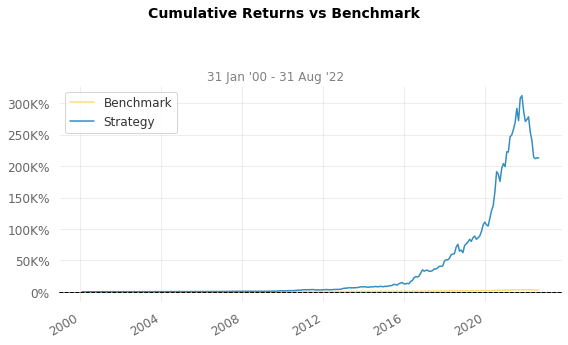

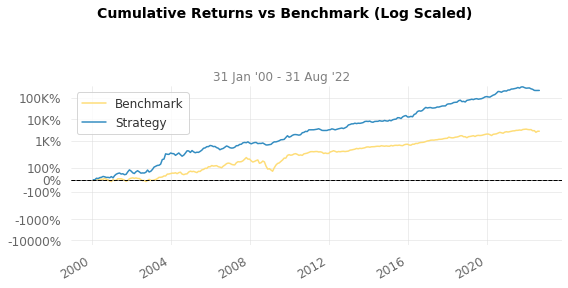

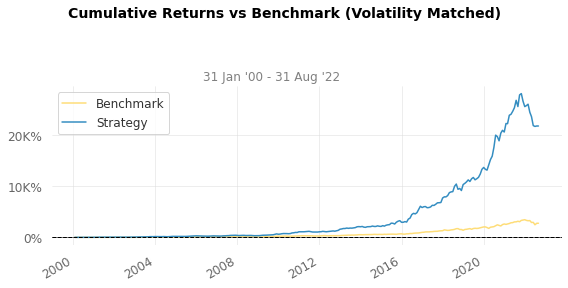

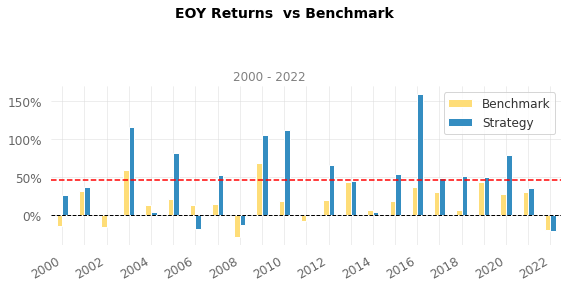

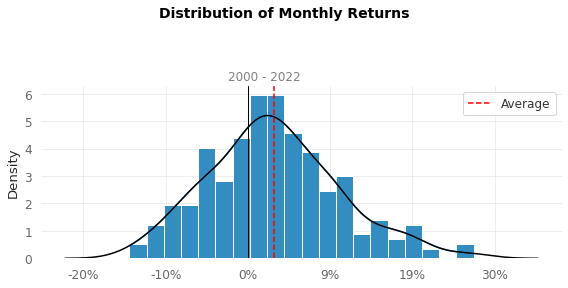

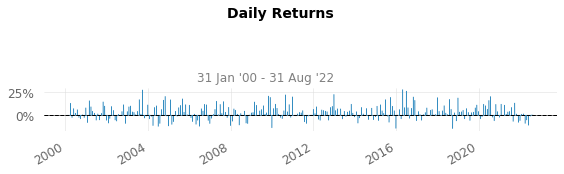

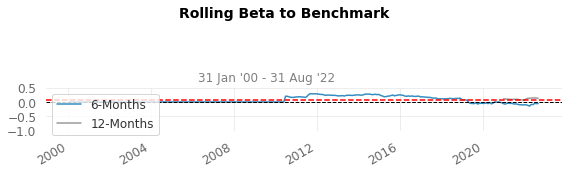

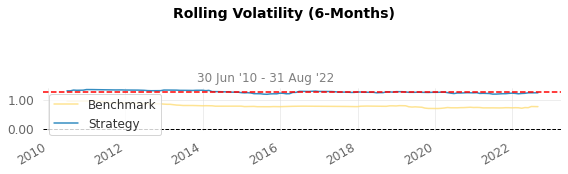

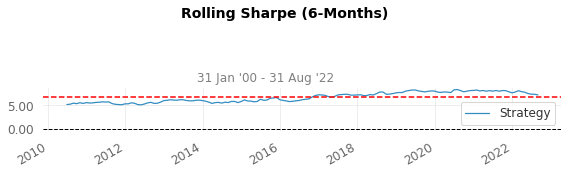

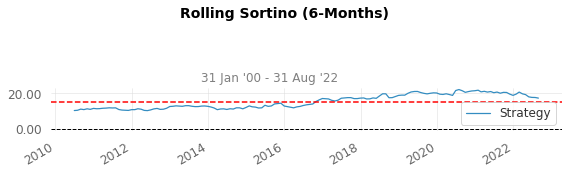

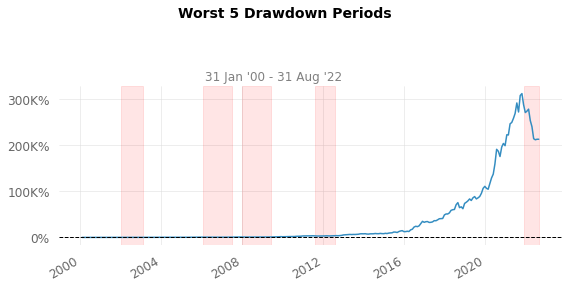

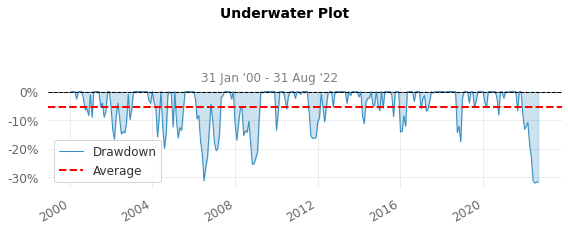

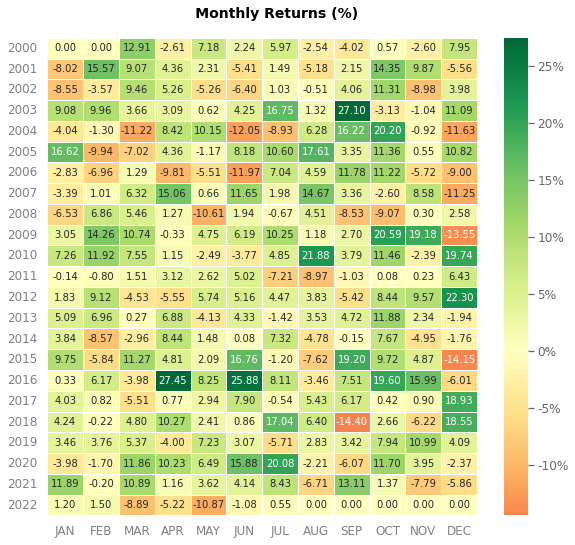

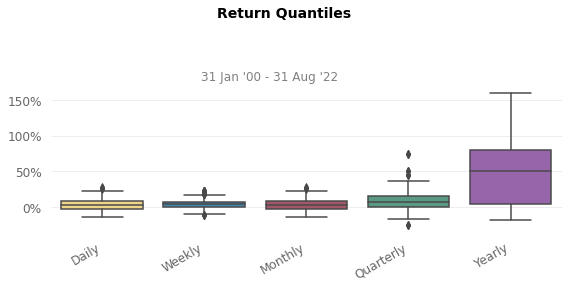

In [21]:
qs.reports.plots(returns, benchmark_monthly_returns, mode='full')
#qs.reports.plots(returns, lookback_returns[3], mode='full')